In [1]:
import sys
sys.path.insert(0, '../')
import movement_classifier.utils as utils
import movement_classifier.data_loader as data_loader
import movement_classifier.model_funcs as model_funcs
import movement_classifier.gpt_reverse_model as gpt_reverse_model

from os.path import dirname, join as pjoin
import os
import sys
import math

import dlc2kinematics
# from sequitur.models import CONV_LSTM_AE
# from sequitur.models import LSTM_AE 
from sequitur import quick_train
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch.nn as nn
import numpy as np
from torch.nn import MSELoss
from matplotlib import animation
import torch
import copy
from IPython.display import HTML
from celluloid import Camera
%matplotlib inline
import pandas as pd
import plotly.express as px
import torch
import plotly
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.io as sio

In [2]:
"""load dataframes for the modelling"""
path_file = "../data/03_processed/interpolation"
data_dict = data_loader.load_data_dict(path_file)
data_dict.keys()
# np.unique(data_dict["labels_name"])
data = data_dict['input_model']
train_input = torch.Tensor(data[0:1050,:,0:633])
#  train_Set should be ==>  [num_examples, seq_len, *num_features]
train_set  = train_input.permute(2,0,1)
train_set.shape
test_input = torch.Tensor(data[1050:1250,:,0:633])
test_set  = test_input.permute(2,0,1)
val_input = torch.Tensor(data[1250:1319,:,0:633])
val_set  = val_input.permute(2,0,1)
val_set.shape

torch.Size([633, 69, 28])

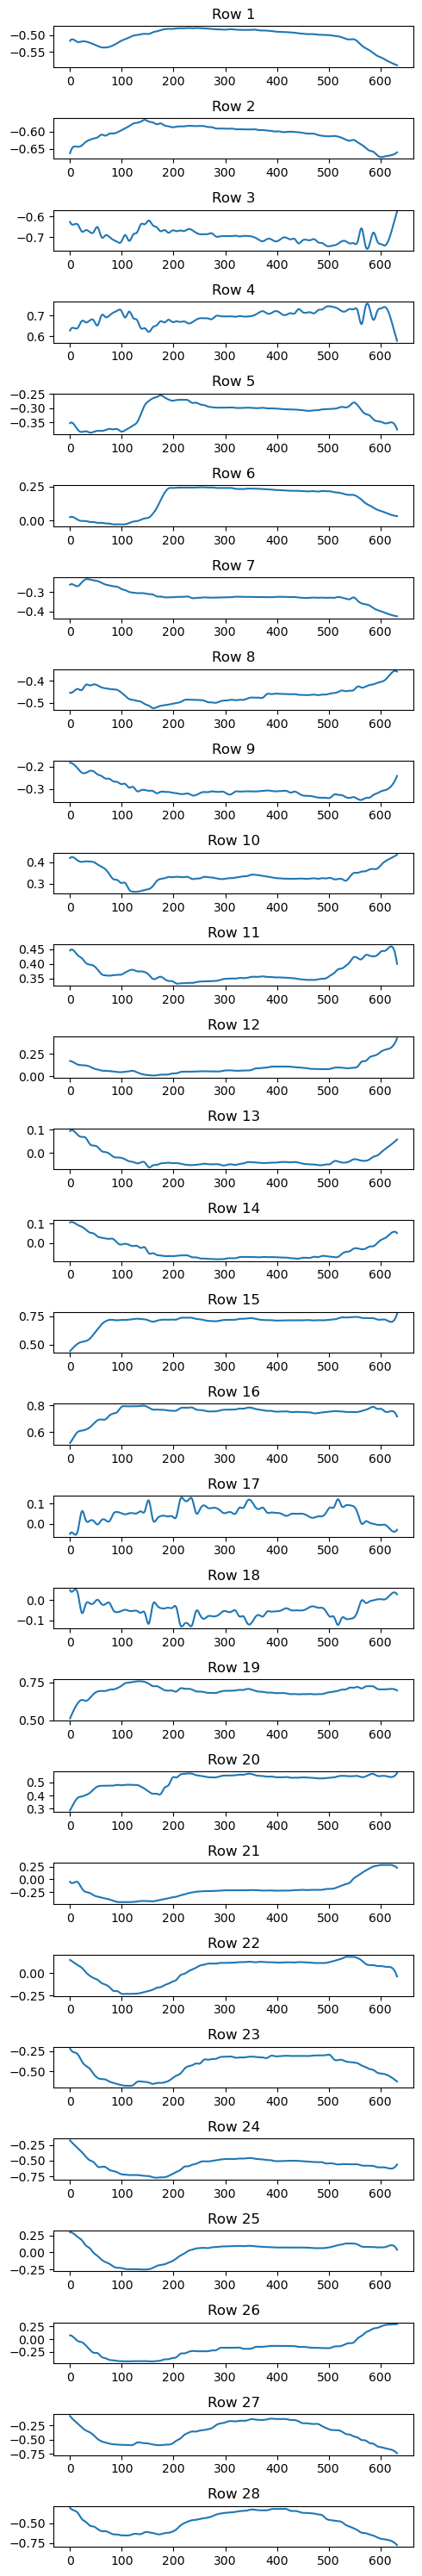

In [3]:
sample = np.array(test_input[0])
sample.shape
fig, axs = plt.subplots(nrows=28, figsize=(5, 30))
data = sample
# plot each row in a separate subplot
for i in range(28):
    axs[i].plot(data[i])
    axs[i].set_title('Row {}'.format(i+1))

# adjust the layout of the subplots
plt.tight_layout()

# show the plot
plt.show()


In [4]:
seq_len, n_features = train_set.shape[1], train_set.shape[2]

In [8]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.sigmoid(self.fc5(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 28)
        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x




class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:


def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  # or nn.L1loss(reduction = "sum")
  criterion = MSELoss()
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true
      seq_pred = model(seq_true)
      # print("#######################",seq_true.shape, "shape true seq ")
      # print("#######################",seq_pred.shape, "shape of output")
      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    val_data_predicted = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true
        seq_pred = model(seq_true)
        val_data_predicted.append(seq_pred)
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history,val_data_predicted

In [13]:

#  Training

for t in range(633):
    t= t+40
    print( "t= ", t)
    model = Autoencoder()
    train_data = train_set[0,:]
    test_data = test_set[0,:]
    val_data = val_set[0,:]

    model, history, val_data_predicted = train_model(
        model, 
        train_data, 
        val_data, 
        n_epochs=100)

t=  40
Epoch 1: train loss 5159.958631195795 val loss 5362.179064764493
Epoch 2: train loss 5157.915003277007 val loss 5362.179291213768
Epoch 3: train loss 5157.75586504255 val loss 5362.178350033967
Epoch 4: train loss 5157.738736332484 val loss 5362.178668478261
Epoch 5: train loss 5157.73790318807 val loss 5362.178491564764
Epoch 6: train loss 5157.73248941694 val loss 5362.177953747736
Epoch 7: train loss 5157.721738917033 val loss 5362.17723194067
Epoch 8: train loss 5157.722387499128 val loss 5362.177529155344
Epoch 9: train loss 5157.72170358567 val loss 5362.178066972373
Epoch 10: train loss 5157.722071235294 val loss 5362.17677196558
Epoch 11: train loss 5157.71828053429 val loss 5362.174967447917
Epoch 12: train loss 5157.72497273763 val loss 5362.178350033967
Epoch 13: train loss 5157.726701998029 val loss 5362.177691915761
Epoch 14: train loss 5157.71811248416 val loss 5362.172908174819
Epoch 15: train loss 5157.716799091158 val loss 5362.175384963768
Epoch 16: train loss 

KeyboardInterrupt: 

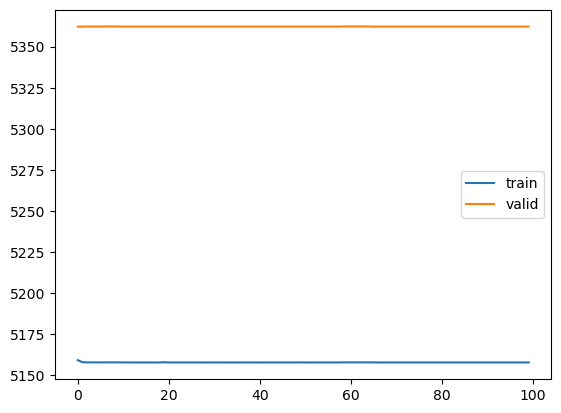

In [12]:
plt.plot(history["train"], label='train')
plt.plot(history["val"], label='valid')
plt.legend()
plt.show()